In [1]:
import sys
sys.path.append("./PatchTST_self_supervised/")
from types import SimpleNamespace
import xarray as xr
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np


import matplotlib.pyplot as plt

from PatchTST_self_supervised.src.models.patchTST import PatchTST
from PatchTST_self_supervised.src.learner import Learner, transfer_weights
from PatchTST_self_supervised.src.callback.tracking import *
from PatchTST_self_supervised.src.callback.patch_mask import *
from PatchTST_self_supervised.src.callback.transforms import *
from PatchTST_self_supervised.src.metrics import *
from PatchTST_self_supervised.src.basics import set_device
from PatchTST_self_supervised.datautils import *

from src.data.datamodule import DataLoaders


## Dataset and Dataloader

In [2]:
PATH = "./"

ds_full = xr.open_zarr("s3://wfp-ops-userdata/public-share/ndvi_world.zarr")

new_time_chunk_size = -1
new_latitude_chunk_size = 50
new_longitude_chunk_size = 50
target_chunks = {'time':
                 new_time_chunk_size, 'latitude': new_latitude_chunk_size, 'longitude': new_longitude_chunk_size}

max_mem = "12GB"

time_step_size = 30  # Define batch size
num_batches = ds_full.dims['time'] // time_step_size


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'NDVI Rechunked/ndvi_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

NDVI = xr.concat(concatenated_ds_list, dim='time')


concatenated_ds_list = []

for i in range(num_batches):
    target_store = PATH + f'RFH Rechunked/rfh_target_store_batch_{i}.zarr'
    ds_rechunked = xr.open_zarr(target_store)
    concatenated_ds_list.append(ds_rechunked)

# Concatenate all datasets along the time dimension
RFH = xr.concat(concatenated_ds_list, dim='time')


In [3]:
bbox_africa = [-17.314453,-34.957995,51.855469,13.667338]

In [4]:
bbox_africa = [-17.314453,-34.957995,51.855469,13.667338]
NDVI_africa =NDVI.sel(
    latitude=slice(bbox_africa[3], bbox_africa[1]),
    longitude=slice(bbox_africa[0], bbox_africa[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)


RFH_africa =RFH.sel(
    latitude=slice(bbox_africa[3], bbox_africa[1]),
    longitude=slice(bbox_africa[0], bbox_africa[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)




In [5]:

NDVI_lta = NDVI_africa.sel(time=slice("2003-02-01","2018-12-31"))
NDVI_lta  = NDVI_lta .groupby(NDVI_lta.time.dt.strftime("%m-%d")).mean()
NDVI_lta = NDVI_lta.sel(strftime=NDVI.time.dt.strftime("%m-%d"))

RFH_lta = RFH_africa.sel(time=slice("2003-02-01","2018-12-31"))
RFH_lta  = RFH_lta .groupby(RFH_lta.time.dt.strftime("%m-%d")).mean()
RFH_lta = RFH_lta.sel(strftime=RFH.time.dt.strftime("%m-%d"))


In [6]:
ndvi_array = NDVI_africa.band.values
rfh_array = RFH_africa.band.values
time_array = RFH_africa.time.values

In [ ]:
bbox = [26.542969,13.239945,33.398438,16.804541] #sudan

NDVI_sudan =NDVI.sel(
    latitude=slice(bbox[3], bbox[1]),
    longitude=slice(bbox[0], bbox[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)


RFH_sudan =RFH.sel(
    latitude=slice(bbox[3], bbox[1]),
    longitude=slice(bbox[0], bbox[2])
).isel(
    latitude=slice(None, None, 5), 
    longitude=slice(None, None, 5)
)




In [ ]:
pip install cartopy

# Dataset Class

In [7]:
class Rain_Ndvi_Dataset(Dataset):
    def __init__(self, ndvi_array, rfh_array,time_array, lat_index,lon_index, size=None, split='train', scale=True):
        if size is None:
            self.seq_len = 30
            self.label_len = 10
            self.pred_len = 10
        else:
            self.seq_len, self.label_len, self.pred_len = size
            
        assert split in ['train', 'val', 'test']
        self.split = split
        self.scale = scale
        # self.ndvi_xarray = ndvi_xarray
        # self.rfh_xarray = rfh_xarray
        self.ndvi_array = ndvi_array
        self.rfh_array = rfh_array
        self.time_array = time_array
        self.features = ['rfh', 'ndvi']
        self.lat_index = lat_index
        self.lon_index = lon_index


        self.initialize_data_for_epoch()

    def initialize_data_for_epoch(self):
        # Randomly select a pixel
        lat, lon = self.select_random_pixel()
        
        # while np.isnan(self.ndvi_xarray.isel(latitude=lat, longitude=lon, time=0).band.values) or np.isnan(self.rfh_xarray.isel(latitude=lat, longitude=lon, time=0).band.values):
        #     lat, lon = self.select_random_pixel()
        # Generate DataFrame for the selected pixel
        if self.split == "test":
            print("(lat, lon) selected for test:",  (lat, lon))
            
        self.dataframe = self.generate_pixel_dataframe(lat, lon)
        # Read and split data
        self.__read_data__()

    def select_random_pixel(self):
        lat = self.lat_index
        lon = self.lon_index
        return lat, lon

    def generate_pixel_dataframe(self, lat, lon):
        ndvi_df = pd.DataFrame(self.ndvi_array[:,lat,lon], columns=['band'])
        time_values = self.time_array  
        ndvi_df = ndvi_df.reset_index()
        ndvi_df['time'] = time_values
        ndvi = ndvi_df[['time', 'band']]
        ndvi.rename(columns={'band': 'ndvi'}, inplace=True)
        ndvi.set_index('time', inplace=True)
        
        
        rfh_df = pd.DataFrame(self.rfh_array[:,lat,lon], columns=['band'])
        time_values = self.time_array  
        rfh_df = rfh_df.reset_index()
        rfh_df['time'] = time_values
        rfh = rfh_df[['time', 'band']]
        rfh.rename(columns={'band': 'rfh'}, inplace=True)
        rfh.set_index('time', inplace=True)
        df = pd.concat([rfh, ndvi], axis=1)
        return df

    def __read_data__(self):
        df = self.dataframe.copy()

        if self.scale:
            self.scaler = StandardScaler()
            df[self.features] = self.scaler.fit_transform(df[self.features])
            

        train_size = int(0.7 * len(df))
        val_size = int(0.15 * len(df))

        if self.split == 'train':
            self.data = df.iloc[:train_size]
        elif self.split == 'val':
            self.data = df.iloc[train_size:train_size + val_size]
        else:
            self.data = df.iloc[train_size + val_size:]

    def __getitem__(self, index):
        # Choose a random start index for the sequence
        max_start_index = len(self.data) - self.seq_len - self.pred_len
        if max_start_index < 1:
            raise ValueError("Dataset is too small for the specified sequence and prediction lengths.")
        random_start = np.random.randint(0, max_start_index)

        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end 
        r_end = r_begin + self.pred_len
        

        seq_x = self.data.iloc[s_begin:s_end][self.features].values
        seq_y = self.data.iloc[r_begin:r_end][self.features].values


        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        if self.scale:
            return self.scaler.inverse_transform(data)
        return data

# Test

In [8]:
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 3e-4,
    
    'batch_size':128, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 200, # number of pre-training epochs
    'n_epochs_finetune' : 50, # number of pre-training epochs
    'pretrained_model_id': 1, # id of the saved pretrained model
    
    
    'save_finetuned_model': './finetuned_d128',
    
    'save_path' :  'saved_models' + '/masked_patchtst/'
    
}

config_obj = SimpleNamespace(**config)

def get_model(args, head_type, weight_path=None):
    """
    c_in: number of variables
    """
    # get number of patches
    num_patch = (max(args.sequence_length, args.patch_len)-args.patch_len) // args.stride + 1    
    print('number of patches:', num_patch)
    
    # get model
    model = PatchTST(c_in=args.c_in,
                target_dim=args.prediction_length,
                patch_len=args.patch_len,
                stride=args.stride,
                num_patch=num_patch,
                n_layers=4, #number of Transformer layers
                n_heads=16,#number of Transformer heads
                d_model= 128, #128, #Transformer d_model
                shared_embedding=True,
                d_ff=512, #Tranformer MLP dimension                              
                dropout=2e-1, #Transformer dropout
                head_dropout=2e-1, #head dropout
                act='relu',
                head_type=head_type,
                res_attention=False
                )    
    if weight_path: model = transfer_weights(weight_path, model)
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model

def get_dls(config_obj, dataset_class,lat,lon):
    size = [config_obj.sequence_length, 0, config_obj.prediction_length]
    dls = DataLoaders(
            datasetCls=dataset_class,
            dataset_kwargs={
                'ndvi_array':ndvi_array , 
                'rfh_array':rfh_array ,
                'time_array':time_array ,
                'size':size,
                'scale':True,
                'lat_index': lat,
                'lon_index': lon
            },
            batch_size=config_obj.batch_size,
            workers=config_obj.num_workers,
            )

    dls.vars, dls.len = dls.train.dataset[0][0].shape[1], config_obj.sequence_length
    dls.c = dls.train.dataset[0][1].shape[0]
    return dls

In [9]:
dls = get_dls(config_obj, Rain_Ndvi_Dataset,0,0)

(lat, lon) selected for test: (0, 0)


In [10]:
# Assuming dls.test.dataset.data is your DataFrame
df = dls.test.dataset.data

# Convert the index to a column
df_reset = df.reset_index()

# Now the time column is accessible as df_reset['time']
time_column = df_reset['time']


array(['2020-07-01T00:00:00.000000000', '2020-07-11T00:00:00.000000000',
       '2020-07-21T00:00:00.000000000', '2020-08-01T00:00:00.000000000',
       '2020-08-11T00:00:00.000000000', '2020-08-21T00:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-09-11T00:00:00.000000000',
       '2020-09-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [11]:
def test_func(args, weight_path,lat,lon):
    
    # get dataloader
    print('end-to-end finetuning')
    # get dataloader
    dls = get_dls(args, Rain_Ndvi_Dataset,lat,lon)
    mean,std= dls.test.dataset.scaler.mean_,dls.test.dataset.scaler.scale_
    # get model 
    model = get_model(args, head_type='prediction').to('cpu')
    
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=True)] if args.revin else []
    cbs += [PatchCB(patch_len=args.patch_len, stride=args.stride)]
    learn = Learner(dls, model,cbs=cbs)
    out  = learn.test(dls.test, weight_path=weight_path+'.pth', scores=[mse,mae])         # out: a list of [pred, targ, score]
    print('score:', out[2])
    # save results
    pd.DataFrame(np.array(out[2]).reshape(1,-1), columns=['mse','mae']).to_csv(args.save_path + args.save_finetuned_model + '_acc.csv', float_format='%.6f', index=False)
    return out, dls

In [10]:
NDVI_africa.longitude.shape[0],NDVI_africa.latitude.shape[0]

(277, 195)

In [8]:
Predictions=np.zeros((9,NDVI_africa.latitude.shape[0],NDVI_africa.longitude.shape[0],2))
Targets=np.zeros((9,NDVI_africa.latitude.shape[0],NDVI_africa.longitude.shape[0],2))

In [9]:
import torch
from datetime import datetime

# Assuming get_dls and other necessary functions and variables are defined elsewhere
batch_idx = 1

for lat in range(0, NDVI_africa.latitude.shape[0]):
    for lon in range(NDVI_africa.longitude.shape[0]):
        
        out = torch.load(f"saved_models/denorm_Africa_Forecast//out_{lat}_{lon}.pt")
        pred, targ = out[0], out[1]
        Predictions[:, lat, lon] = pred[batch_idx, :, :] 
        Targets[:, lat, lon] = targ[batch_idx, :, :] 


In [12]:

s_begin = batch_idx
s_end = s_begin + config_obj.sequence_length
r_begin = s_end 
r_end = r_begin + config_obj.prediction_length


In [13]:

s_begin = batch_idx
s_end = s_begin + config_obj.sequence_length
r_begin = s_end 
r_end = r_begin + config_obj.prediction_length



rfh_lta = RFH_lta.isel(time=slice(r_begin-1,r_end-1)).band.values
ndvi_lta = NDVI_lta.isel(time=slice(r_begin-1,r_end-1) ).band.values


In [14]:
# febrary - March - January  RMSE  1st  dekad, 2nd dekad  

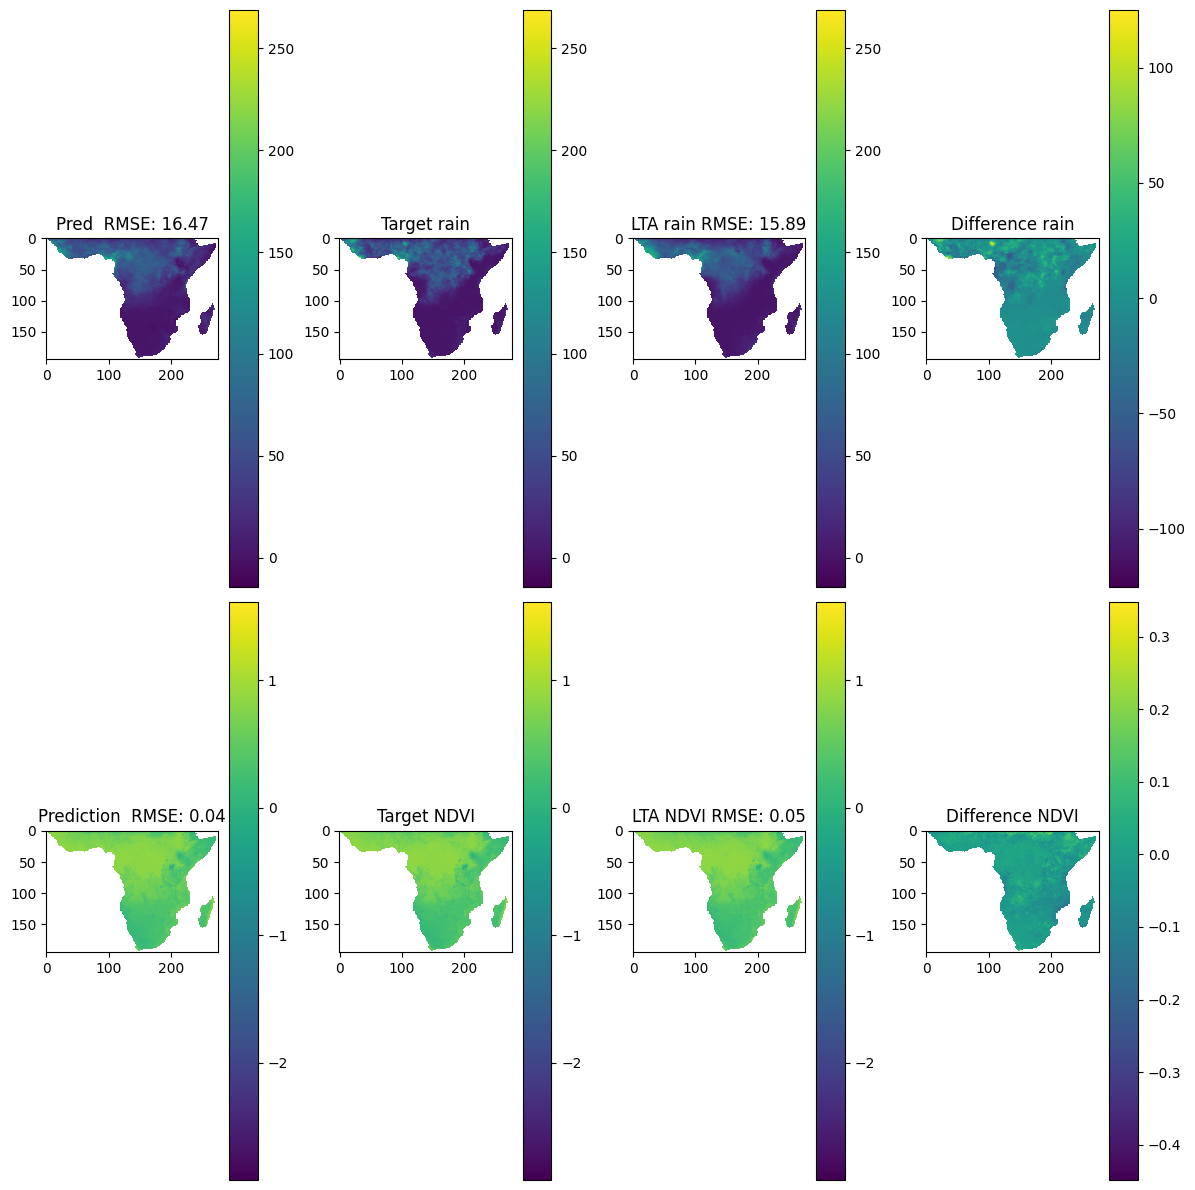

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_rmse(target, prediction):
    # Flatten arrays and remove NaN values
    target_flat = target.flatten()
    prediction_flat = prediction.flatten()
    mask = ~np.isnan(target_flat) & ~np.isnan(prediction_flat)

    # Calculate RMSE only on non-NaN values
    return np.sqrt(mean_squared_error(target_flat[mask], prediction_flat[mask]))

lead_time = 8
fig, axs = plt.subplots(2, 4, figsize=(12, 12))

# Calculate RMSE values
rmse_rain_patchtst = calculate_rmse(Targets[lead_time, :, :, 0], Predictions[lead_time, :, :, 0])
rmse_ndvi_patchtst = calculate_rmse(Targets[lead_time, :, :, 1], Predictions[lead_time, :, :, 1])

rmse_rain_lta = calculate_rmse(Targets[lead_time, :, :, 0], rfh_lta[lead_time])
rmse_ndvi_lta = calculate_rmse(Targets[lead_time, :, :, 1], ndvi_lta[lead_time])

# First row (Rain)
im1 = axs[0, 0].imshow(Predictions[lead_time, :, :, 0])
axs[0, 0].set_title(f'Pred  RMSE: {rmse_rain_patchtst:.2f}')

im2 = axs[0, 1].imshow(Targets[lead_time, :, :, 0])
axs[0, 1].set_title('Target rain')

im3 = axs[0, 2].imshow(rfh_lta[lead_time])
axs[0, 2].set_title(f'LTA rain RMSE: {rmse_rain_lta:.2f}')

im4 = axs[0, 3].imshow(Targets[lead_time, :, :, 0] - Predictions[lead_time, :, :, 0])
axs[0, 3].set_title('Difference rain')


# Second row (NDVI)
im5 = axs[1, 0].imshow(Predictions[lead_time, :, :, 1])
axs[1, 0].set_title(f'Prediction  RMSE: {rmse_ndvi_patchtst:.2f}')

im6 = axs[1, 1].imshow(Targets[lead_time, :, :, 1])
axs[1, 1].set_title('Target NDVI')

im7 = axs[1, 2].imshow(ndvi_lta[lead_time])
axs[1, 2].set_title(f'LTA NDVI RMSE: {rmse_ndvi_lta:.2f}')

im8 = axs[1, 3].imshow(Targets[lead_time, :, :, 1] - Predictions[lead_time, :, :, 1])
axs[1, 3].set_title('Difference NDVI')

# Find global min and max for consistent scaling
vmin_rain = min(im1.get_clim()[0], im2.get_clim()[0], im3.get_clim()[0])
vmax_rain = max(im1.get_clim()[1], im2.get_clim()[1], im3.get_clim()[1])

vmin_ndvi = min(im5.get_clim()[0], im6.get_clim()[0], im7.get_clim()[0])
vmax_ndvi = max(im5.get_clim()[1], im6.get_clim()[1], im7.get_clim()[1])

# Set same scaling and add colorbars
for im in [im1, im2, im3]:
    im.set_clim(vmin_rain, vmax_rain)
fig.colorbar(im1, ax=axs[0, 0])
fig.colorbar(im1, ax=axs[0, 1])
fig.colorbar(im1, ax=axs[0, 2])

for im in [im5, im6, im7]:
    im.set_clim(vmin_ndvi, vmax_ndvi)
fig.colorbar(im5, ax=axs[1, 0])
fig.colorbar(im5, ax=axs[1, 1])
fig.colorbar(im5, ax=axs[1, 2])

# Separate colorbars for difference images
fig.colorbar(im4, ax=axs[0, 3])
fig.colorbar(im8, ax=axs[1, 3])

plt.tight_layout()
plt.show()


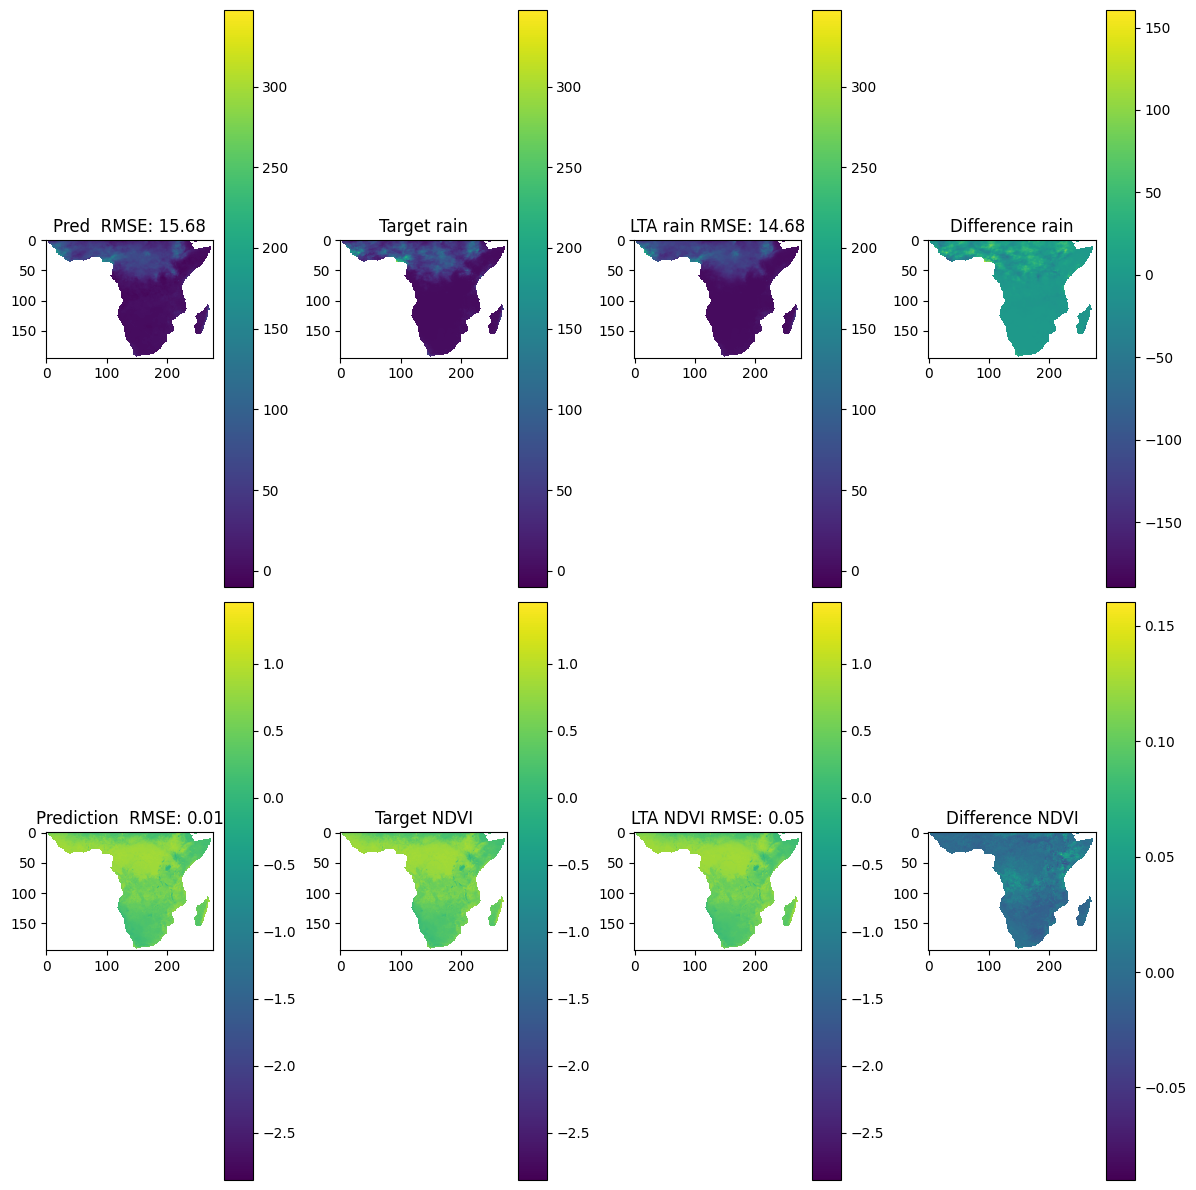

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_rmse(target, prediction):
    # Flatten arrays and remove NaN values
    target_flat = target.flatten()
    prediction_flat = prediction.flatten()
    mask = ~np.isnan(target_flat) & ~np.isnan(prediction_flat)

    # Calculate RMSE only on non-NaN values
    return np.sqrt(mean_squared_error(target_flat[mask], prediction_flat[mask]))

lead_time = 0
fig, axs = plt.subplots(2, 4, figsize=(12, 12))

# Calculate RMSE values
rmse_rain_patchtst = calculate_rmse(Targets[lead_time, :, :, 0], Predictions[lead_time, :, :, 0])
rmse_ndvi_patchtst = calculate_rmse(Targets[lead_time, :, :, 1], Predictions[lead_time, :, :, 1])

rmse_rain_lta = calculate_rmse(Targets[lead_time, :, :, 0], rfh_lta[lead_time])
rmse_ndvi_lta = calculate_rmse(Targets[lead_time, :, :, 1], ndvi_lta[lead_time])

# First row (Rain)
im1 = axs[0, 0].imshow(Predictions[lead_time, :, :, 0])
axs[0, 0].set_title(f'Pred  RMSE: {rmse_rain_patchtst:.2f}')

im2 = axs[0, 1].imshow(Targets[lead_time, :, :, 0])
axs[0, 1].set_title('Target rain')

im3 = axs[0, 2].imshow(rfh_lta[lead_time])
axs[0, 2].set_title(f'LTA rain RMSE: {rmse_rain_lta:.2f}')

im4 = axs[0, 3].imshow(Targets[lead_time, :, :, 0] - Predictions[lead_time, :, :, 0])
axs[0, 3].set_title('Difference rain')


# Second row (NDVI)
im5 = axs[1, 0].imshow(Predictions[lead_time, :, :, 1])
axs[1, 0].set_title(f'Prediction  RMSE: {rmse_ndvi_patchtst:.2f}')

im6 = axs[1, 1].imshow(Targets[lead_time, :, :, 1])
axs[1, 1].set_title('Target NDVI')

im7 = axs[1, 2].imshow(ndvi_lta[lead_time])
axs[1, 2].set_title(f'LTA NDVI RMSE: {rmse_ndvi_lta:.2f}')

im8 = axs[1, 3].imshow(Targets[lead_time, :, :, 1] - Predictions[lead_time, :, :, 1])
axs[1, 3].set_title('Difference NDVI')

# Find global min and max for consistent scaling
vmin_rain = min(im1.get_clim()[0], im2.get_clim()[0], im3.get_clim()[0])
vmax_rain = max(im1.get_clim()[1], im2.get_clim()[1], im3.get_clim()[1])

vmin_ndvi = min(im5.get_clim()[0], im6.get_clim()[0], im7.get_clim()[0])
vmax_ndvi = max(im5.get_clim()[1], im6.get_clim()[1], im7.get_clim()[1])

# Set same scaling and add colorbars
for im in [im1, im2, im3]:
    im.set_clim(vmin_rain, vmax_rain)
fig.colorbar(im1, ax=axs[0, 0])
fig.colorbar(im1, ax=axs[0, 1])
fig.colorbar(im1, ax=axs[0, 2])

for im in [im5, im6, im7]:
    im.set_clim(vmin_ndvi, vmax_ndvi)
fig.colorbar(im5, ax=axs[1, 0])
fig.colorbar(im5, ax=axs[1, 1])
fig.colorbar(im5, ax=axs[1, 2])

# Separate colorbars for difference images
fig.colorbar(im4, ax=axs[0, 3])
fig.colorbar(im8, ax=axs[1, 3])

plt.tight_layout()
plt.show()


In [ ]:
NDVI_chad = []

# RMSE 

In [21]:
def calculate_rmse(target, prediction):
    # Flatten arrays and remove NaN values
    target_flat = target.flatten()
    prediction_flat = prediction.flatten()
    mask = ~np.isnan(target_flat) & ~np.isnan(prediction_flat)

    # Calculate RMSE only on non-NaN values
    return np.sqrt(mean_squared_error(target_flat[mask], prediction_flat[mask]))


rmse_rain_patchtst=[]
rmse_ndvi_patchtst=[]
rmse_rain_lta=[]
rmse_ndvi_lta=[]

for lead_time in range(9):
    rmse_rain_patchtst.append( calculate_rmse(Targets[lead_time, :, :, 0], Predictions[lead_time, :, :, 0]))
    rmse_ndvi_patchtst.append(calculate_rmse(Targets[lead_time, :, :, 1], Predictions[lead_time, :, :, 1]))

    rmse_rain_lta.append(calculate_rmse(Targets[lead_time, :, :, 0], rfh_lta[lead_time]))
    rmse_ndvi_lta.append(calculate_rmse(Targets[lead_time, :, :, 1], ndvi_lta[lead_time]))


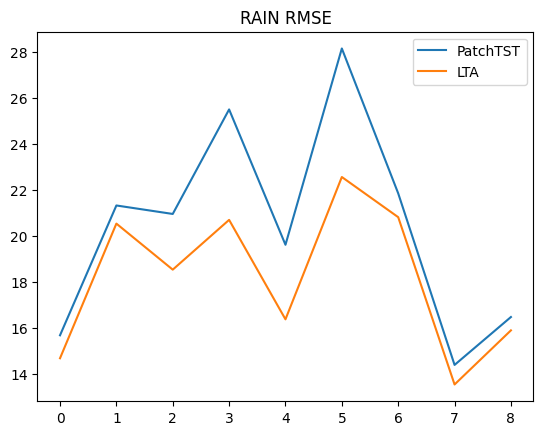

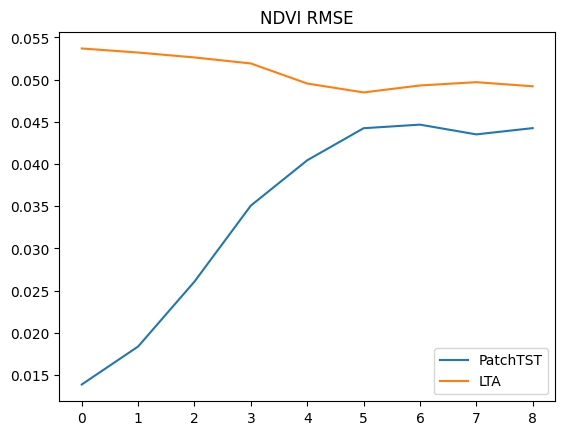

In [22]:
plt.plot(rmse_rain_patchtst,label="PatchTST")
plt.plot(rmse_rain_lta, label="LTA")
plt.title("RAIN RMSE")
plt.legend()
plt.show()

plt.plot(rmse_ndvi_patchtst,label="PatchTST")
plt.plot(rmse_ndvi_lta, label="LTA")
plt.title("NDVI RMSE")
plt.legend()

plt.show()